In [1]:
import sqlite3
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy
# paths to local databases
# path to databases
data_folder = './../../../s3/data'
city_geom  = data_folder + '/d000_lookuptables/city_pts_urban_audit2021.sqlite'
fua_geom   = data_folder + '/d000_lookuptables/fua_pts_urban_audit2021.sqlite'
lookuptable= data_folder + '/d000_lookuptables/lookuptables.gpkg'
city_cube  = data_folder + '/c001_city_cube/C_urban_cube_sh.sqlite'

## Get the Eurostat Table and attribute description, city names

In [2]:
# get Eurostat variables
con = sqlite3.connect(city_cube)
# read full table
eurostat_all = pd.read_sql_query("SELECT * FROM c_urban_cube_eurostat", con)
con.close()
eurostat_all

,index,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,EN1002V,AT001C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,EN1002V,AT002C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,EN1002V,AT003C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,EN1002V,AT004C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,EN1002V,AT005C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47683,6132,TT1080V,UK024C,None,None,None,None,None,None,None,...,NaN,51.3,45.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47684,6133,TT1080V,UK027C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47685,6134,TT1080V,UK029C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,102.61,NaN,NaN,NaN,NaN,NaN
47686,6135,TT1080V,UK030C,None,None,None,None,None,None,None,...,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# also get lookup tables with attribute description and city names
con_l = sqlite3.connect(lookuptable)
eurostat_attributes = pd.read_sql_query("SELECT * FROM L_eurostat", con_l)
city_names = pd.read_sql_query("SELECT URAU_CODE, URAU_NAME FROM L_core_city_urb_atl18", con_l)
con_l.close()
# city code has a trailing number, lets drop it for now
city_names.URAU_CODE = city_names.URAU_CODE.str[:-1]

In [4]:
# join tables with two consecutive merge (dropping rows that do not match) 
eurostat_extended = eurostat_all.merge(
    city_names, how="inner", left_on="urau_code", right_on="URAU_CODE").merge(
    eurostat_attributes, how="inner", left_on="indic_code", right_on="variable_code")
# drop duplicated columns
eurostat_extended.drop(columns=["index_x", "index_y", "variable_code", "URAU_CODE"], inplace=True)

## Code significance  
indic_code (type of data): e.g., DE1001V = total population (see: https://www.espon.eu/sites/default/files/attachments/CB02_Inception_report_Annex_I.pdf) 

City name from urau_code, here: https://ec.europa.eu/eurostat/documents/3217494/5729233/RY_CH_ANNEXES_2011-EN.PDF.pdf/deb1dbbc-e8d3-4dd2-aa76-fae2f36a0bd9?t=1414776025000 

In [5]:
eurostat_extended.head()

,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,1998,...,2016,2017,2018,2019,2020,2021,URAU_NAME,eurostat_table,variable_description,uc1_priority
0,EN1002V,AT001C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Wien,urb_cenv,Total number of hours of sunshine per day,2
1,EN1002V,AT002C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Graz,urb_cenv,Total number of hours of sunshine per day,2
2,EN1002V,AT003C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Linz,urb_cenv,Total number of hours of sunshine per day,2
3,EN1002V,AT004C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Salzburg,urb_cenv,Total number of hours of sunshine per day,2
4,EN1002V,AT005C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Innsbruck,urb_cenv,Total number of hours of sunshine per day,2


In [6]:
print('Features: ', eurostat_extended.variable_description.unique())
print('Number of Features: ', len(eurostat_extended.variable_description.unique()))

Features:  ['Total number of hours of sunshine per day'
 'Average temperature of warmest month - degrees'
 'Average temperature of coldest month - degrees' 'Rainfall - litre/m²'
 'Number of days ozone O3 concentrations exceed 120 µg/m³'
 'Number of hours nitrogen dioxide NO2 concentrations exceed 200 µg/m³'
 'Number of days particulate matter PM10 concentrations exceed 50 µg/m³'
 'Accumulated ozone concentration in excess 70 µg/m³'
 'Annual average concentration of NO2 (µg/m³)'
 'Annual average concentration of PM10 (µg/m³)' 'Total use of water - m³'
 'Price of a m³ of domestic water - Euro'
 'Share of the urban waste water load (in population equivalents) treated according to the applicable standard -%'
 'Municipal waste generated (domestic and commercial), total - 1000 t'
 'Number of deaths per year under 65 due to diseases of the circulatory or respiratory systems'
 'Total deaths under 65 per year' 'Total deaths per year'
 'Share of severely materially deprived persons -%'
 'Share o

## Keep only the total population per year

In [7]:
population_tot = eurostat_extended[eurostat_extended['indic_code'] == 'DE1001V']
population_tot = population_tot.reset_index(drop=True)
# population_tot.to_csv('TotalPopulation.csv', index=False)
population_tot

,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,1998,...,2016,2017,2018,2019,2020,2021,URAU_NAME,eurostat_table,variable_description,uc1_priority
0,DE1001V,AT001C,1539848.0,None,None,None,None,1595402.0,1609631.0,1606843.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Wien,urb_cpop1,"Population on the 1st of January, total",2
1,DE1001V,AT002C,237810.0,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Graz,urb_cpop1,"Population on the 1st of January, total",2
2,DE1001V,AT003C,203044.0,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Linz,urb_cpop1,"Population on the 1st of January, total",2
3,DE1001V,AT004C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Salzburg,urb_cpop1,"Population on the 1st of January, total",2
4,DE1001V,AT005C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Innsbruck,urb_cpop1,"Population on the 1st of January, total",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,DE1001V,ES019C,None,None,None,None,None,None,None,None,...,NaN,790423.0,791054.0,792617.0,797590.0,NaN,Bilbao,urb_cpop1,"Population on the 1st of January, total",2
649,DE1001V,ES024C,None,None,None,None,None,None,None,None,...,356696.0,357347.0,360405.0,364815.0,368105.0,NaN,L'Hospitalet de Llobregat,urb_cpop1,"Population on the 1st of January, total",2
650,DE1001V,ES056C,None,None,None,None,None,None,None,None,...,87278.0,87153.0,86883.0,86894.0,87054.0,NaN,Viladecans,urb_cpop1,"Population on the 1st of January, total",2
651,DE1001V,ES059C,None,None,None,None,None,None,None,None,...,399562.0,398847.0,399456.0,401574.0,404809.0,NaN,Zamora,urb_cpop1,"Population on the 1st of January, total",2


## Study data availability across cities and years

In [27]:
# make availability matrix
# drop descriptive columns, keep only value columns, i.e. years
av_table = population_tot.drop(columns=["indic_code", "urau_code", "URAU_NAME", "eurostat_table", "variable_description", "uc1_priority"])
av_matrix = ~pd.isnull(av_table)
# sum over rows: returns the number of years with non-null data
cities_av = av_matrix.sum(axis=1)
# sum over columns: returns the number of available cities for that year
years_av = av_matrix.sum(axis=0)

In [28]:
print(cities_av)
print(years_av)

0      15
1      10
2      10
3       9
4       9
       ..
648     4
649     6
650     6
651     6
652     3
Length: 653, dtype: int64
1991    169
1992    191
1993    125
1994    125
1995    191
1996    208
1997    178
1998    194
1999    215
2000    237
2001    326
2002    264
2003    206
2004    402
2005    313
2006    327
2007    327
2008    394
2009    420
2010    514
2011    580
2012    563
2013    578
2014    568
2015    512
2016    515
2017    571
2018    552
2019    426
2020    355
2021    260
dtype: int64


## Cities with full data

In [12]:
nonnan = population_tot
for col in nonnan.columns:
    nonnan = nonnan[~pd.isnull(nonnan[col])]

In [13]:
nonnan

,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,1998,...,2016,2017,2018,2019,2020,2021,URAU_NAME,eurostat_table,variable_description,uc1_priority
5,DE1001V,BE001C,954045.0,951217.0,950339.0,949070.0,951580.0,948122.0,950597.0,953175.0,...,1201129.0,1199095.0,1205492.0,1215289.0,1223364.0,1226329.0,Bruxelles / Brussel,urb_cpop1,"Population on the 1st of January, total",2
6,DE1001V,BE002C,467518.0,465783.0,465102.0,462880.0,459072.0,455852.0,453030.0,449745.0,...,517731.0,520859.0,523591.0,526439.0,530014.0,530627.0,Antwerpen,urb_cpop1,"Population on the 1st of January, total",2
7,DE1001V,BE003C,230246.0,230232.0,229821.0,228490.0,227483.0,226464.0,225469.0,224545.0,...,257226.0,259462.0,260329.0,262205.0,263687.0,264019.0,Gent,urb_cpop1,"Population on the 1st of January, total",2
8,DE1001V,BE004C,206214.0,206903.0,207045.0,206898.0,206491.0,205591.0,204899.0,203853.0,...,202602.0,201884.0,202341.0,202637.0,203314.0,238412.0,Charleroi,urb_cpop1,"Population on the 1st of January, total",2
10,DE1001V,BE006C,117063.0,116717.0,116871.0,116724.0,116273.0,115815.0,115500.0,115573.0,...,118219.0,118393.0,118526.0,118569.0,118916.0,118802.0,Brugge,urb_cpop1,"Population on the 1st of January, total",2
120,DE1001V,EE001C,476591.0,470299.0,449688.0,438346.0,429563.0,421249.0,413851.0,408238.0,...,423420.0,426538.0,430805.0,434562.0,438341.0,438341.0,Tallinn,urb_cpop1,"Population on the 1st of January, total",2
121,DE1001V,EE002C,114046.0,113238.0,108795.0,105863.0,104874.0,103356.0,101750.0,100705.0,...,93687.0,93124.0,96506.0,96974.0,95430.0,95430.0,Tartu,urb_cpop1,"Population on the 1st of January, total",2
149,DE1001V,FI001C,492400.0,497542.0,501514.0,508588.0,515765.0,525031.0,532053.0,539363.0,...,628208.0,635181.0,643272.0,648042.0,653835.0,656920.0,Helsinki / Helsingfors,urb_cpop1,"Population on the 1st of January, total",2
150,DE1001V,FI002C,172560.0,173797.0,174859.0,176149.0,179251.0,182742.0,186026.0,188726.0,...,225118.0,228274.0,231853.0,235239.0,238140.0,241009.0,Tampere / Tammerfors,urb_cpop1,"Population on the 1st of January, total",2
151,DE1001V,FI003C,159180.0,159403.0,159916.0,160390.0,162370.0,164744.0,166929.0,168772.0,...,185908.0,187604.0,189669.0,191331.0,192962.0,194391.0,Turku / Åbo,urb_cpop1,"Population on the 1st of January, total",2


In [29]:
# alternative method, using availability matrix
population_31yrs = population_tot[cities_av == 31]

## Discover patterns in update frequency
Let's plot an heatmap showing data availability for each city across years.

We order the cities by number of available years, with cities with most years on top.

From the heatmap we can see that:
- there is not a clear update frequency for all cities
- there is not a year in which all cities have reported data
- in general if cities start reporting data for 2/3 consecutive years they keep reporting in the following years (to be verified)
- latest year 2021 not (yet) reported for many cities

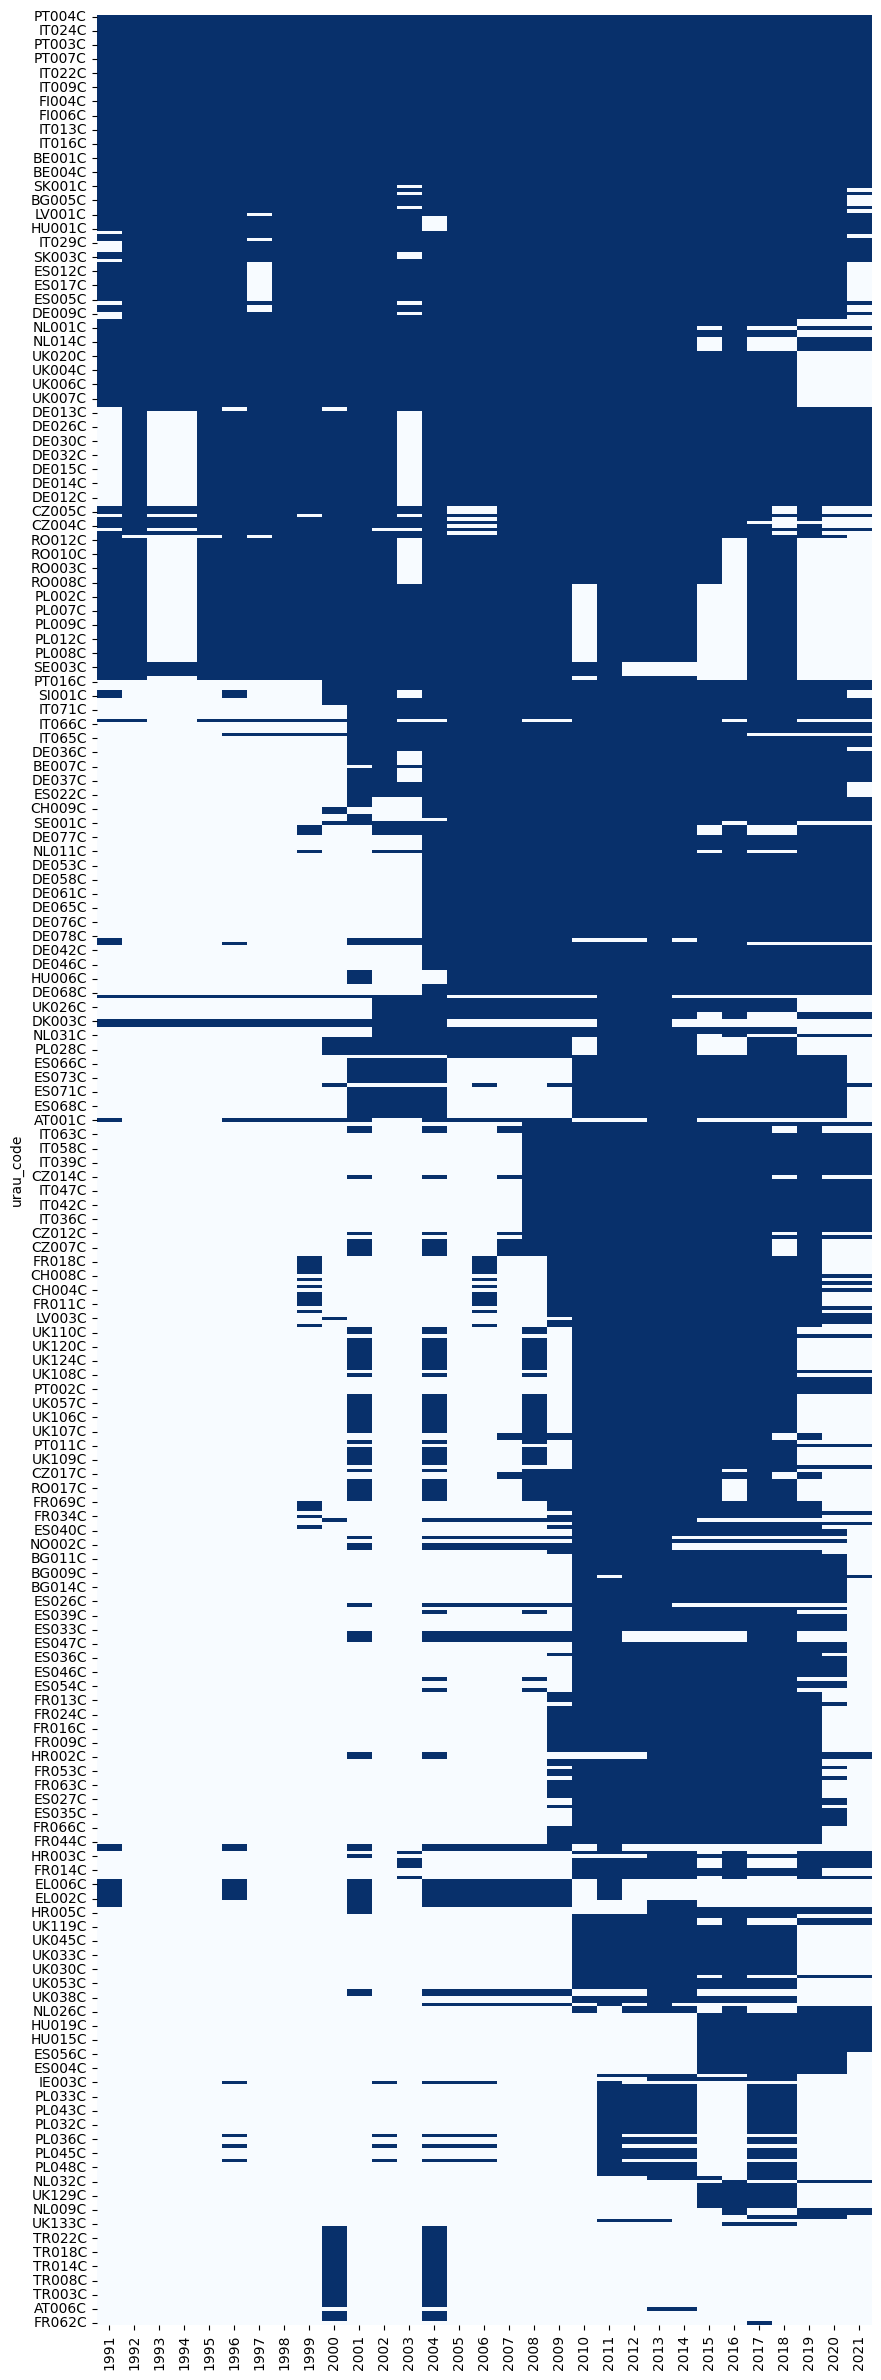

In [25]:
# plot when is data available (blue = available, white = not available)
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,30)) 
# order cities by number of available years
av_matrix.set_index(population_tot["urau_code"], inplace=True)
av_matrix_toplot = av_matrix.sort_values(by="n_av_yrs", ascending=False).drop(columns="n_av_yrs")
ax = sns.heatmap(av_matrix_toplot.astype(int), cmap="Blues", cbar=False)

In [ ]:
## Cities with at least 20 years of data
population_20yrs = population_tot[cities_av >= 20]
population_20yrs

## Save

In [ ]:
nonnan = nonnan.reset_index(drop=True)
nonnan.to_csv('CompleteData.csv', index=False)

## Plot existing cities (countries)

In [ ]:
lis = []
for index, row in nonnan.iterrows():
    arr = numpy.asarray(row)
    arr = numpy.delete(arr, [0, 1, 2])
    arr = arr.astype(float)
    lis.append(arr)

In [ ]:
x = range(1991, 2022)
i = 0
for arr in lis:
    plt.plot(x, arr)
    plt.title("Population in: " + nonnan.urau_code.iloc[i])
    plt.savefig("Plots/" + nonnan.urau_code.iloc[i]+ ".png")
    plt.show()
    i = i + 1

## Cities with nan data (for all years)

In [ ]:
nans = population_tot
for col in nans.columns:
    nans = nans[pd.isnull(nans[col])]
nans

## Distribution of data x: City indice; y: number of years with available data

In [ ]:
available = []
for index, row in population_sum.iterrows():
    arr = numpy.asarray(row)
    arr = numpy.delete(arr, [0, 1, 2])
    arr.astype(float)
    i = 0
    for v in arr:
        if(not pd.isnull(v)):
            i = i + 1
    available.append(i)

In [ ]:
a = range(1, len(population_sum)+1)
plt.bar(a, available, align='center', width=1, edgecolor='black')
plt.axhline(y = 31, color = 'r', linestyle = '-')
plt.show()

## Statistics:

In [ ]:
# array = numpy.asarray(available)
print("Number of cities\countries: ", len(population_tot))
print("Number of cities\countries with complete data: ", len(nonnan))
print("Number of cities\countries with no data: ", len(nans))
print("Maximum number of available years: ", cities_av.max())
print("Minimum number of available years: ", cities_av.min())
print("Average number of available years: ", cities_av.mean())
print("Standard deviation: ", cities_av.std())
# print("Missing values: (", population_tot.isna().sum().sum(), " missing from ", population_tot.drop(columns=['index', 'indic_code', 'urau_code']).size, ") = ", 100*population_sum.isna().sum().sum()/population_sum.drop(columns=['index', 'indic_code', 'urau_code']).size, "%")

## Distribution

In [ ]:
unique_values, frequencies = numpy.unique(array, return_counts=True)

In [ ]:
plt.bar(unique_values, frequencies)
plt.xlabel("Available years")
plt.ylabel("Frequency")
plt.title("Distribution of available years")
plt.savefig("Plots/Distribution.png")
plt.show()

## Missing data for each feature

In [26]:
for i in eurostat_extended.variable_description.unique():
    data = eurostat_extended[eurostat_extended['variable_description'] == i]
    data = data.reset_index(drop=True)
    # data.to_csv(i + '.csv', index=False)
    print(
        "Missing data: (", data.isna().sum().sum(), " missing from ", data.drop(columns=['variable_description', 'urau_code']).size,") = ", 100*data.isna().sum().sum()/(len(data)*31), "%. Variable:", i)

Missing data: ( 9060  missing from  11620 ) =  88.02953750485814 %. Variable: Total number of hours of sunshine per day
Missing data: ( 9673  missing from  12565 ) =  86.91706352772037 %. Variable: Average temperature of warmest month - degrees
Missing data: ( 9791  missing from  12705 ) =  87.0079090020439 %. Variable: Average temperature of coldest month - degrees
Missing data: ( 9721  missing from  12635 ) =  86.86444464301671 %. Variable: Rainfall - litre/m²
Missing data: ( 7221  missing from  12915 ) =  63.12614739050616 %. Variable: Number of days ozone O3 concentrations exceed 120 µg/m³
Missing data: ( 7082  missing from  12845 ) =  62.24839588643755 %. Variable: Number of hours nitrogen dioxide NO2 concentrations exceed 200 µg/m³
Missing data: ( 9176  missing from  14420 ) =  71.84466019417475 %. Variable: Number of days particulate matter PM10 concentrations exceed 50 µg/m³
Missing data: ( 6295  missing from  11690 ) =  60.79775932006954 %. Variable: Accumulated ozone concentr